# Presentation Skeleton

* Goal was to see if crime rates differed between gentrified and non-gentrified neighborhoods over time, to see both if changes in crime correlate with gentrification, later we might use the analysis to compare with another city. 

* City of Chicago Data called by API (see below), looks at three years [2002, 2010, 2018], and makes a call for up to 400,000 reported cries per year. Because the API throttles API calls that are greater than 400,000 records long, the code below is broken up such that the operations for each year take place one at a time. More elegant code could abbreviate the process, but slowing down the processing speed made the API call more stable and consistent. 

* To connect crime data, with fbi code books, gentrification indeces and demographic information, the majority of the code is a series of pivot-like data manipulations, resulting in tables that provide summary counts by crime category [violent, nonviolent, white collar] and in neighborhoods that were coded [gentrified, not gentrified]. From an intial 1.2m reported crimes, our subest is closer to 300,000, including 30 of 70 community areas.

* Next we merge with demographic data to adjust count of reported crimes by population to generate a crime rate. The crime rate per neighborhood type, crime type, and year were then plotted in a series of box plots. 

#### Example Socrata Module for City of Chicago Data. https://dev.socrata.com/foundry/data.cityofchicago.org/6zsd-86xi
* I don't use the sodapy package, the code is more efficient, but I'm trying to demonstrate that I'm learning the DS_Bootcamp code

In [1]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import warnings;
warnings.filterwarnings('ignore');

# import pandas as pd
from sodapy import Socrata

MyAppToken = 'PoLZLhceSUgObx1Disd6WIQS1'

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
client = Socrata('data.cityofchicago.org',
                 MyAppToken,
                 username="stephen.monteiro@northwestern.edu",
                 password="FackeTestPw0rd")

In [2]:
#Dependencies
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pprint as pp
import os
import csv
year = [2002, 2010, 2018]


In [3]:
# fbi_codex Needed to index Crime Reports into summary categories
fbi_codex = pd.read_csv('crime_resources/fbi_codex.csv')
fbi_index = fbi_codex[['fbi_Crime_type','fbi_code_key','ds_fbi_group']]
fbi_index = fbi_index.dropna()

# gent_codex Needed to index Crime Reports into summary categories
gent_codex = pd.read_csv('../../Resources/UIC_gentrification_index_neighborhood_list_final.csv')
gent_concat = gent_codex["Type"].str.split(" - ", n = 1, expand = True) 
gent_codex["Classification"] = gent_concat[1]
gent_codex["Class_Code"] = gent_concat[0]
gent_fin = gent_codex.rename(columns={"No.": "community_area"})

# cca_codex will allow us to convert raw crime into a crime rate for 2010 and an approzimation for 2002
cca_codex = pd.read_csv('../../Resources/ReferenceCCA20102014.csv')

# cca_codex2018 will allow us to convert raw crime into a crime rate for 2018

cca_codex2018 = pd.read_csv('../../Resources/DemoData2018.csv')

# display all imported csvs so we can remember what we're working with later
display(fbi_index.head())
display(gent_fin.head())
display(cca_codex.head())
display(cca_codex2018.head())

,fbi_Crime_type,fbi_code_key,ds_fbi_group
0,Aggravated Assault,04A,Violent
1,Aggravated Battery,04B,Violent
2,Arson,9,Nonviolent
3,Burglary,5,Nonviolent
4,Criminal Sexual Abuse,17,Nonviolent


,community_area,Neighborhood,1970,1980,1990,2000,2010,1970-2010,Change,Type,Classification,Class_Code
0,77,Edgewater,7,9,9,7,9,2,No Change,1 - Upper Class,Upper Class,1
1,9,Edison Park,10,9,11,11,11,1,No Change,1 - Upper Class,Upper Class,1
2,12,Forest Glen,11,11,11,11,9,-2,No Change,1 - Upper Class,Upper Class,1
3,4,Lincoln Square,9,7,5,11,11,2,No Change,1 - Upper Class,Upper Class,1
4,13,North Park,9,11,11,11,11,2,No Change,1 - Upper Class,Upper Class,1


,GEOG,2000_POP,2010_POP,POP_CHANGE,TOT_POP,UND19,A20_34,A35_49,A50_64,A65_79,...,IND,INDperc,TRANS,TRANSperc,AG,Agperc,OPEN,OPENperc,VACANT,VACperc
0,Albany Park,57655,51542,-6113,52930,14351,14417,11908,8016,3062,...,19.929938,1.621420,414.736812,33.741335,0.0,0.0,25.293181,2.057752,6.672887,0.542880
1,Archer Heights,12644,13393,749,13971,4319,3277,2876,2058,1020,...,344.677590,26.848038,558.599207,43.511076,0.0,0.0,12.295439,0.957731,32.517216,2.532870
2,Armour Square,12032,13391,1359,13907,3037,3206,2434,2651,1639,...,18.046053,2.831079,343.648391,53.911829,0.0,0.0,15.019249,2.356231,14.366379,2.253809
3,Ashburn,39584,41081,1497,42809,12553,8473,8808,8724,3201,...,104.574805,3.362800,1064.249375,34.222945,0.0,0.0,259.867667,8.356535,83.385680,2.681424
4,Auburn Gresham,55928,48743,-7185,47611,13305,9014,8262,9515,5541,...,57.729492,2.393450,834.435659,34.595488,0.0,0.0,59.011603,2.446606,119.183176,4.941304


,GEOG,2000_POP,2010_POP,TOT_POP,UND19,A20_34,A35_49,A50_64,A65_74,A75_84,...,ARABIC,KOREAN,OTHER_ASIAN,OTHER_EURO,OTHER_UNSPEC,2000_WHITE,2000_HISP,2000_BLACK,2000_ASIAN,2000_OTHER
0,Albany Park,57655.0,51542.0,51575.0,13354.0,13738.0,11975.0,8232.0,2329.0,1343.0,...,621.0,650.0,1801.0,3294.0,563.0,15866.0,26741.0,1907.0,10178.0,2963.0
1,Archer Heights,12644.0,13393.0,13233.0,4016.0,2933.0,2879.0,1897.0,907.0,369.0,...,24.0,0.0,0.0,64.0,0.0,6752.0,5485.0,74.0,48.0,285.0
2,Armour Square,12032.0,13391.0,13699.0,2997.0,2824.0,2539.0,2541.0,1371.0,1043.0,...,1.0,6.0,138.0,218.0,0.0,2062.0,448.0,2046.0,7305.0,171.0
3,Ashburn,39584.0,41081.0,43283.0,12983.0,8368.0,8998.0,8477.0,2855.0,977.0,...,444.0,9.0,91.0,309.0,258.0,14546.0,6674.0,17045.0,408.0,911.0
4,Auburn Gresham,55928.0,48743.0,45770.0,11432.0,9224.0,7941.0,9587.0,4041.0,2700.0,...,0.0,11.0,61.0,202.0,80.0,237.0,347.0,54862.0,45.0,437.0


#### API Call for Start Year
* Currently using 2002 rather than 2001, because 2001 data lacks 'community_area' for most reported crimes. With more time, you could use loops and conditions on 'latitude' and 'longitude' to fill 'community area'.
* Export the data to CSV so that there is a reference file in case original data source is ever corrupted, or non-responsive to API calls.
* For more on the City of Chicago Crime Data: https://dev.socrata.com/foundry/data.cityofchicago.org/6zsd-86xi

* FIGURE OUT: how to remove decimal from neighborhood

In [4]:
results = client.get("6zsd-86xi", year=2002, limit=400000)
results_df = pd.DataFrame.from_records(results) # Convert to pandas DataFrame # results_df.head()
start_results = results_df[['community_area','fbi_code','date','description','latitude','longitude','primary_type','year']]
start_results['community_area'] = pd.to_numeric(start_results['community_area'], errors='coerce')
start_format = start_results.sort_values('community_area')
start_format.to_csv('report_reference_data/start_tfile.csv')    
start_format.head()


,community_area,fbi_code,date,description,latitude,longitude,primary_type,year
30977,0.0,07,2002-02-04T19:30:00.000,AUTOMOBILE,41.881536805,-87.616595359,MOTOR VEHICLE THEFT,2002
179351,0.0,14,2002-07-09T10:00:00.000,TO VEHICLE,41.693049104,-87.690994029,CRIMINAL DAMAGE,2002
182008,0.0,26,2002-07-05T10:30:00.000,TELEPHONE THREAT,41.798886497,-87.790543844,OTHER OFFENSE,2002
261732,0.0,08B,2002-09-21T13:15:00.000,SIMPLE,41.970514812,-87.83665128,BATTERY,2002
345621,0.0,06,2002-12-17T00:00:00.000,OVER $500,41.799089601,-87.790549465,THEFT,2002


#### Combining the Crime Data with our Research Indexes (Gentrification & FBI Crime Category)

In [5]:
baseyear_fbiindex = start_format.merge(fbi_index, left_on='fbi_code', right_on='fbi_code_key')
b_crimecat_cca = baseyear_fbiindex.merge(gent_fin, left_on='community_area', right_on='community_area')
b_crimecat_cca.to_csv('report_reference_data/b_crimecat_cca.csv') # display(b_crimecat_cca.columns)
b_crimecat_cca.head()

,community_area,fbi_code,date,description,latitude,longitude,primary_type,year,fbi_Crime_type,fbi_code_key,...,1970,1980,1990,2000,2010,1970-2010,Change,Type,Classification,Class_Code
0,1.0,14,2002-09-23T02:00:00.000,TO PROPERTY,42.005357685,-87.67178356,CRIMINAL DAMAGE,2002,Vandalism,14,...,9,9,3,1,3,-6,Negative,7 - Mild Decline,Mild Decline,7
1,1.0,14,2002-11-02T03:00:00.000,TO VEHICLE,42.003585275,-87.665679761,CRIMINAL DAMAGE,2002,Vandalism,14,...,9,9,3,1,3,-6,Negative,7 - Mild Decline,Mild Decline,7
2,1.0,14,2002-04-29T16:00:00.000,TO VEHICLE,42.005832909,-87.669964736,CRIMINAL DAMAGE,2002,Vandalism,14,...,9,9,3,1,3,-6,Negative,7 - Mild Decline,Mild Decline,7
3,1.0,14,2002-12-20T01:00:00.000,TO VEHICLE,42.013831423,-87.670779489,CRIMINAL DAMAGE,2002,Vandalism,14,...,9,9,3,1,3,-6,Negative,7 - Mild Decline,Mild Decline,7
4,1.0,14,2002-04-30T05:10:00.000,TO PROPERTY,42.009172046,-87.662788123,CRIMINAL DAMAGE,2002,Vandalism,14,...,9,9,3,1,3,-6,Negative,7 - Mild Decline,Mild Decline,7


In [6]:
b_crimecat_cca_clean = b_crimecat_cca[['community_area', 'Neighborhood', 'fbi_code','fbi_Crime_type', 'ds_fbi_group', 'Classification', 'Class_Code',]]
b_crimecat_cca_group = b_crimecat_cca_clean.groupby(by=['ds_fbi_group','Classification']).count() #relevant_results.sort_values('fbi_code')
crime_reset = b_crimecat_cca_group.reset_index()
print("Count of FBI Crime Categories by Gentrification Pathway")
crime_reset.drop(columns=['community_area', 'Neighborhood', 'fbi_code','fbi_Crime_type',])
crime_reset.pivot(index='Classification', columns='ds_fbi_group', values='Class_Code')


Count of FBI Crime Categories by Gentrification Pathway


ds_fbi_group,Nonviolent,Violent,White Collar
Classification,,,
Extreme Poverty,20149,14378,532
Gentrification,15487,8145,2254
Middle Class,9259,4900,843
Mild Decline,4699,2619,391
Moderate Decline,12323,7756,497
Not Gentrification,3026,1762,222
Poverty,3802,2348,106
Serious Decline,24420,15807,1020
Upper Class,2217,1221,215


#### Slicing a subset of crimes in Neighborhoods classified as either "Not Gentrified" or "Gentrified" according to the UIC index

In [7]:
b_crimecat_cca_clean['Class_Code'] = pd.to_numeric(b_crimecat_cca_clean['Class_Code'], errors='coerce') # b_crimecat_cca_clean.dtypes
ngb1 = b_crimecat_cca_clean.loc[b_crimecat_cca_clean['Class_Code'] < 3]
ngb2 = b_crimecat_cca_clean.loc[b_crimecat_cca_clean['Class_Code'] == 5]
gb6 = b_crimecat_cca_clean.loc[b_crimecat_cca_clean['Class_Code'] == 6]
combo = [ngb1, ngb2]
nGentrified = pd.concat(combo)
nGentrified["DS_Subset"] = "Not Gentrified"
gb6["DS_Subset"] = "Gentrified"
neighborhodtype_bycrime = [nGentrified, gb6]
b_neighbors = pd.concat(neighborhodtype_bycrime)
b_neighbors_reset = b_neighbors.groupby(by=['DS_Subset','Neighborhood','ds_fbi_group']).count()
b_neighbors_dropem = b_neighbors_reset.reset_index()
b_neighbors_dropem.drop(columns=['Classification','community_area','fbi_code','fbi_Crime_type',], inplace=True)
print("Count of FBI Crime Categories by Gentrification Pathway")
b_neighbors_final = b_neighbors_dropem.groupby(by=['DS_Subset','Neighborhood','ds_fbi_group']).sum().unstack('ds_fbi_group')
base_year_ngdata = b_neighbors_final.reset_index()# .pivot(index='Neighborhood', columns='ds_fbi_group', values='Class_Code')
base_year_ngdata['Total'] = base_year_ngdata.sum(axis=1)
base_year_ngdata.to_csv('report_reference_data/close_year_ngdata.csv')
base_year_ngdata

Count of FBI Crime Categories by Gentrification Pathway


DS_Subset     Neighborhood Class_Code                       \
ds_fbi_group                                  Nonviolent Violent White Collar   
0                 Gentrified        Lake View       1382     657          263   
1                 Gentrified     Lincoln Park       1162     504          209   
2                 Gentrified             Loop       1214     587          450   
3                 Gentrified  Near North Side       2824    1552          567   
4                 Gentrified  Near South Side        694     456           55   
5                 Gentrified   Near West Side       2840    1518          213   
6                 Gentrified     North Center        664     309           70   
7                 Gentrified           Uptown       1721    1017          242   
8                 Gentrified        West Town       2986    1545          185   
9             Not Gentrified    Armour Square        262     113           15   
10            Not Gentrified          Beverly        311     160           46   
11            Not Gentrified       Bridgeport        694     429           39   
12            Not Gentrified  Calumet Heights        481     269           27   
13            Not Gentrified         Clearing        442     216           45   
14            Not Gentrified          Dunning        710     315           43   
15            Not Gentrified        Edgewater        977     568          105   
16            Not Gentrified      Edison Park        110      51            4   
17            Not Gentrified      Forest Glen        208      65           14   
18            Not Gentrified   Garfield Ridge       1035     474          151   
19            Not Gentrified        Hyde Park        494     282           71   
20            Not Gentrified      Irving Park       1072     569           68   
21            Not Gentrified   Jefferson Park        405     208           53   
22            Not Gentrified          Kenwood        447     417           36   
23            Not Gentrified   Lincoln Square        671     419           69   
24            Not Gentrified     Logan Square       2070    1220          168   
25            Not Gentrified      Morgan Park        824     482           42   
26            Not Gentrified  Mount Greenwood        248     135           27   
27            Not Gentrified       North Park        251     118           23   
28            Not Gentrified     Norwood Park        436     223           39   
29            Not Gentrified     Portage Park       1356     597           98   
30            Not Gentrified       West Ridge        998     553           97   

             Total  
ds_fbi_group        
0             2302  
1             1875  
2             2251  
3             4943  
4             1205  
5             4571  
6             1043  
7             2980  
8             4716  
9              390  
10             517  
11            1162  
12             777  
13             703  
14            1068  
15            1650  
16             165  
17             287  
18            1660  
19             847  
20            1709  
21             666  
22             900  
23            1159  
24            3458  
25            1348  
26             410  
27             392  
28             698  
29            2051  
30            1648

## Rinse and Repeat the API for our Mid Year slice, 2010
* Because their are bandwidth limits on the API call, the code was more stable if it was arranged sequentially. Again, a smarter coder could probably make this a loop, but they get paid enough to afford a Chicago City Data Subscription

In [8]:
midresults = client.get("6zsd-86xi", year=2010, limit=400000)
midresults_df = pd.DataFrame.from_records(midresults) # Convert to pandas DataFrame # results_df.head()
mid_results = midresults_df[['community_area','fbi_code','date','description','latitude','longitude','primary_type','year']]
mid_results['community_area'] = pd.to_numeric(mid_results['community_area'], errors='coerce')
mid_results.groupby(by=['fbi_code']).count() #relevant_results.sort_values('fbi_code')
mid_results.sort_values(['community_area'])
mid_results.to_csv('report_reference_data/mid_tfile.csv')    
mid_results.head()

,community_area,fbi_code,date,description,latitude,longitude,primary_type,year
0,71.0,02,2010-01-01T00:01:00.000,PREDATORY,NaN,NaN,CRIM SEXUAL ASSAULT,2010
1,41.0,11,2010-01-01T12:00:00.000,FINANCIAL IDENTITY THEFT $300 AND UNDER,NaN,NaN,DECEPTIVE PRACTICE,2010
2,23.0,02,2010-03-26T14:00:00.000,AGGRAVATED: OTHER,NaN,NaN,CRIM SEXUAL ASSAULT,2010
3,11.0,02,2010-01-01T00:00:00.000,SEX ASSLT OF CHILD BY FAM MBR,NaN,NaN,OFFENSE INVOLVING CHILDREN,2010
4,67.0,11,2010-01-11T18:20:00.000,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,NaN,DECEPTIVE PRACTICE,2010


In [9]:
midyear_fbiindex = mid_results.merge(fbi_index, left_on='fbi_code', right_on='fbi_code_key')
mid_crimecat_cca = midyear_fbiindex.merge(gent_fin, left_on='community_area', right_on='community_area')
mid_crimecat_cca.to_csv('report_reference_data/mid_crimecat_cca.csv') # display(b_crimecat_cca.columns)
display(mid_crimecat_cca.head())

mid_crimecat_cca_clean = mid_crimecat_cca[['community_area', 'Neighborhood', 'fbi_code','fbi_Crime_type', 'ds_fbi_group', 'Classification', 'Class_Code',]]
mid_crimecat_cca_group = mid_crimecat_cca_clean.groupby(by=['ds_fbi_group','Classification']).count() #relevant_results.sort_values('fbi_code')
mid_crime_reset = mid_crimecat_cca_group.reset_index()
print("Count of FBI Crime Categories by Gentrification Pathway")
mid_crime_reset.drop(columns=['community_area', 'Neighborhood', 'fbi_code','fbi_Crime_type',])
mid_crime_reset.pivot(index='Classification', columns='ds_fbi_group', values='Class_Code')




,community_area,fbi_code,date,description,latitude,longitude,primary_type,year,fbi_Crime_type,fbi_code_key,...,1970,1980,1990,2000,2010,1970-2010,Change,Type,Classification,Class_Code
0,41.0,11,2010-01-01T12:00:00.000,FINANCIAL IDENTITY THEFT $300 AND UNDER,NaN,NaN,DECEPTIVE PRACTICE,2010,Fraud,11,...,9,9,11,7,7,-2,No Change,2 - Middle Class,Middle Class,2
1,41.0,11,2010-04-28T12:00:00.000,FINANCIAL IDENTITY THEFT $300 AND UNDER,NaN,NaN,DECEPTIVE PRACTICE,2010,Fraud,11,...,9,9,11,7,7,-2,No Change,2 - Middle Class,Middle Class,2
2,41.0,11,2010-02-17T11:15:00.000,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,NaN,DECEPTIVE PRACTICE,2010,Fraud,11,...,9,9,11,7,7,-2,No Change,2 - Middle Class,Middle Class,2
3,41.0,11,2010-07-15T12:00:00.000,FRAUD OR CONFIDENCE GAME,41.802505287,-87.585663616,DECEPTIVE PRACTICE,2010,Fraud,11,...,9,9,11,7,7,-2,No Change,2 - Middle Class,Middle Class,2
4,41.0,11,2010-07-18T00:00:00.000,FRAUD OR CONFIDENCE GAME,41.793300208,-87.594025302,DECEPTIVE PRACTICE,2010,Fraud,11,...,9,9,11,7,7,-2,No Change,2 - Middle Class,Middle Class,2


Count of FBI Crime Categories by Gentrification Pathway


ds_fbi_group,Nonviolent,Violent,White Collar
Classification,,,
Extreme Poverty,28259,17017,1394
Gentrification,16213,8943,3499
Middle Class,12208,6505,1327
Mild Decline,6442,3239,532
Moderate Decline,18074,10014,971
Not Gentrification,3594,1994,300
Poverty,4791,2757,199
Serious Decline,37405,20444,2163
Upper Class,2706,1470,343


In [10]:
mid_crimecat_cca_clean['Class_Code'] = pd.to_numeric(mid_crimecat_cca_clean['Class_Code'], errors='coerce') # b_crimecat_cca_clean.dtypes
ngm1 = mid_crimecat_cca_clean.loc[mid_crimecat_cca_clean['Class_Code'] < 3]
ngm2 = mid_crimecat_cca_clean.loc[mid_crimecat_cca_clean['Class_Code'] == 5]
gm6 = mid_crimecat_cca_clean.loc[mid_crimecat_cca_clean['Class_Code'] == 6]
combo = [ngm1, ngm2]
nGentrifiedm = pd.concat(combo)
nGentrifiedm["DS_Subset"] = "Not Gentrified"
gm6["DS_Subset"] = "Gentrified"
mid_neighborhodtype_bycrime = [nGentrifiedm, gm6]
mid_neighbors = pd.concat(mid_neighborhodtype_bycrime)
mid_neighbors_reset = mid_neighbors.groupby(by=['DS_Subset','Neighborhood','ds_fbi_group']).count()
mid_neighbors_dropem = mid_neighbors_reset.reset_index()
mid_neighbors_dropem.drop(columns=['Classification','community_area','fbi_code','fbi_Crime_type',], inplace=True)
mid_neighbors_dropem



,DS_Subset,Neighborhood,ds_fbi_group,Class_Code
0,Gentrified,Lake View,Nonviolent,1744
1,Gentrified,Lake View,Violent,954
2,Gentrified,Lake View,White Collar,529
3,Gentrified,Lincoln Park,Nonviolent,1292
4,Gentrified,Lincoln Park,Violent,551
5,Gentrified,Lincoln Park,White Collar,294
6,Gentrified,Loop,Nonviolent,1612
7,Gentrified,Loop,Violent,831
8,Gentrified,Loop,White Collar,698
9,Gentrified,Near North Side,Nonviolent,2800


In [11]:
print("Count of FBI Crime Categories by Gentrification Pathway")
mid_neighbors_final = mid_neighbors_dropem.groupby(by=['DS_Subset','Neighborhood','ds_fbi_group']).sum().unstack('ds_fbi_group')
mid_year_ngdata = mid_neighbors_final.reset_index()# .pivot(index='Neighborhood', columns='ds_fbi_group', values='Class_Code')
mid_year_ngdata['Total'] = mid_year_ngdata.sum(axis=1)
mid_year_ngdata.to_csv('report_reference_data/close_year_ngdata.csv')
mid_year_ngdata

Count of FBI Crime Categories by Gentrification Pathway


DS_Subset     Neighborhood Class_Code                       \
ds_fbi_group                                  Nonviolent Violent White Collar   
0                 Gentrified        Lake View       1744     954          529   
1                 Gentrified     Lincoln Park       1292     551          294   
2                 Gentrified             Loop       1612     831          698   
3                 Gentrified  Near North Side       2800    1648          866   
4                 Gentrified  Near South Side        562     354           87   
5                 Gentrified   Near West Side       2780    1639          322   
6                 Gentrified     North Center        594     233           96   
7                 Gentrified           Uptown       1769    1000          240   
8                 Gentrified        West Town       3060    1733          367   
9             Not Gentrified    Armour Square        445     222           45   
10            Not Gentrified          Beverly        400     182           93   
11            Not Gentrified       Bridgeport        890     447           57   
12            Not Gentrified  Calumet Heights        632     369           66   
13            Not Gentrified         Clearing        552     300           34   
14            Not Gentrified          Dunning        868     421          101   
15            Not Gentrified        Edgewater       1133     726          162   
16            Not Gentrified      Edison Park        116      74           17   
17            Not Gentrified      Forest Glen        242      84           34   
18            Not Gentrified   Garfield Ridge       1058     439          137   
19            Not Gentrified        Hyde Park        575     353           94   
20            Not Gentrified      Irving Park       1432     833          122   
21            Not Gentrified   Jefferson Park        553     267           79   
22            Not Gentrified          Kenwood        759     532           55   
23            Not Gentrified   Lincoln Square        842     427           93   
24            Not Gentrified     Logan Square       2259    1325          198   
25            Not Gentrified      Morgan Park       1172     625          109   
26            Not Gentrified  Mount Greenwood        367     175           49   
27            Not Gentrified       North Park        373     159           37   
28            Not Gentrified     Norwood Park        478     279           99   
29            Not Gentrified     Portage Park       1676     873          168   
30            Not Gentrified       West Ridge       1686     857          121   

             Total  
ds_fbi_group        
0             3227  
1             2137  
2             3141  
3             5314  
4             1003  
5             4741  
6              923  
7             3009  
8             5160  
9              712  
10             675  
11            1394  
12            1067  
13             886  
14            1390  
15            2021  
16             207  
17             360  
18            1634  
19            1022  
20            2387  
21             899  
22            1346  
23            1362  
24            3782  
25            1906  
26             591  
27             569  
28             856  
29            2717  
30            2664

## Rinse and Repeat the API for our Mid Year slice, 2018
* Because their are bandwidth limits on the API call, the code was more stable if it was arranged sequentially. Again, a smarter coder could probably make this a loop, but they get paid enough to afford a Chicago City Data Subscription

In [12]:
closeresults = client.get("6zsd-86xi", year=2018, limit=400000)
closeresults_df = pd.DataFrame.from_records(closeresults)                    # Convert to pandas DataFrame # results_df.head()
close_results = closeresults_df[['community_area','fbi_code','date','description', 'latitude','longitude','primary_type','year']]
close_results['community_area'] = pd.to_numeric(close_results['community_area'], errors='coerce')
close_results.groupby(by=['fbi_code']).count() #relevant_results.sort_values('fbi_code')
close_results.to_csv('report_reference_data/close_tfile.csv')    
close_results.head()


,community_area,fbi_code,date,description,latitude,longitude,primary_type,year
0,53.0,01A,2018-02-04T01:36:00.000,FIRST DEGREE MURDER,41.68073915,-87.645661144,HOMICIDE,2018
1,77.0,07,2018-01-08T06:50:00.000,AUTOMOBILE,41.99456734,-87.659016317,MOTOR VEHICLE THEFT,2018
2,2.0,07,2018-01-07T21:00:00.000,AUTOMOBILE,42.01220081,-87.69390481,MOTOR VEHICLE THEFT,2018
3,8.0,06,2018-01-05T18:10:00.000,RETAIL THEFT,41.890384236,-87.624109917,THEFT,2018
4,73.0,05,2018-01-08T04:09:00.000,ATTEMPT FORCIBLE ENTRY,41.71716022,-87.643093654,BURGLARY,2018


In [13]:
closeyear_fbiindex = close_results.merge(fbi_index, left_on='fbi_code', right_on='fbi_code_key')
close_crimecat_cca = closeyear_fbiindex.merge(gent_fin, left_on='community_area', right_on='community_area')
close_crimecat_cca.to_csv('report_reference_data/close_crimecat_cca.csv') # display(b_crimecat_cca.columns)
display(close_crimecat_cca.head())

close_crimecat_cca_clean = close_crimecat_cca[['community_area', 'Neighborhood', 'fbi_code','fbi_Crime_type', 'ds_fbi_group', 'Classification', 'Class_Code',]]
close_crimecat_cca_group = close_crimecat_cca_clean.groupby(by=['ds_fbi_group','Classification']).count() #relevant_results.sort_values('fbi_code')
close_crime_reset = close_crimecat_cca_group.reset_index()
print("Count of FBI Crime Categories by Gentrification Pathway")
close_crime_reset.drop(columns=['community_area', 'Neighborhood', 'fbi_code','fbi_Crime_type',])
close_crime_reset.pivot(index='Classification', columns='ds_fbi_group', values='Class_Code')


,community_area,fbi_code,date,description,latitude,longitude,primary_type,year,fbi_Crime_type,fbi_code_key,...,1970,1980,1990,2000,2010,1970-2010,Change,Type,Classification,Class_Code
0,10.0,08B,2018-01-08T04:03:00.000,DOMESTIC BATTERY SIMPLE,41.993999504,-87.813664825,BATTERY,2018,Simple Battery,08B,...,9,9,9,8,7,-2,No Change,2 - Middle Class,Middle Class,2
1,10.0,08B,2018-03-16T09:45:00.000,PRO EMP HANDS NO/MIN INJURY,41.98287878,-87.791440835,BATTERY,2018,Simple Battery,08B,...,9,9,9,8,7,-2,No Change,2 - Middle Class,Middle Class,2
2,10.0,08B,2018-03-26T10:15:00.000,DOMESTIC BATTERY SIMPLE,41.993306464,-87.79663854,BATTERY,2018,Simple Battery,08B,...,9,9,9,8,7,-2,No Change,2 - Middle Class,Middle Class,2
3,10.0,08B,2018-03-30T04:50:00.000,DOMESTIC BATTERY SIMPLE,41.97813688,-87.791458972,BATTERY,2018,Simple Battery,08B,...,9,9,9,8,7,-2,No Change,2 - Middle Class,Middle Class,2
4,10.0,08B,2018-02-26T16:30:00.000,SIMPLE,41.982270338,-87.806941262,BATTERY,2018,Simple Battery,08B,...,9,9,9,8,7,-2,No Change,2 - Middle Class,Middle Class,2


Count of FBI Crime Categories by Gentrification Pathway


ds_fbi_group,Nonviolent,Violent,White Collar
Classification,,,
Extreme Poverty,18035,12625,1767
Gentrification,10075,8671,6660
Middle Class,6914,5058,1923
Mild Decline,3259,2579,811
Moderate Decline,10101,6847,1288
Not Gentrification,1745,1303,544
Poverty,2696,2307,448
Serious Decline,19505,16037,3064
Upper Class,1539,1264,626


In [14]:
close_crimecat_cca_clean['Class_Code'] = pd.to_numeric(close_crimecat_cca_clean['Class_Code'], errors='coerce') # b_crimecat_cca_clean.dtypes
ngc1 = close_crimecat_cca_clean.loc[close_crimecat_cca_clean['Class_Code'] < 3]
ngc2 = close_crimecat_cca_clean.loc[close_crimecat_cca_clean['Class_Code'] == 5]
gc6 = close_crimecat_cca_clean.loc[close_crimecat_cca_clean['Class_Code'] == 6]
combo = [ngc1, ngc2]
nGentrifiedc = pd.concat(combo)
nGentrifiedc["DS_Subset"] = "Not Gentrified"
gc6["DS_Subset"] = "Gentrified"
close_neighborhodtype_bycrime = [nGentrifiedc, gc6]
close_neighbors = pd.concat(close_neighborhodtype_bycrime)
close_neighbors_reset = close_neighbors.groupby(by=['DS_Subset','Neighborhood','ds_fbi_group']).count()
close_neighbors_dropem = close_neighbors_reset.reset_index()
close_neighbors_dropem.drop(columns=['Classification','community_area','fbi_code','fbi_Crime_type',], inplace=True)
print("Count of FBI Crime Categories by Gentrification Pathway")
close_neighbors_final = close_neighbors_dropem.groupby(by=['DS_Subset','Neighborhood','ds_fbi_group']).sum().unstack('ds_fbi_group')
close_year_ngdata = close_neighbors_final.reset_index()# .pivot(index='Neighborhood', columns='ds_fbi_group', values='Class_Code')
close_year_ngdata['Total'] = close_year_ngdata.sum(axis=1)
close_year_ngdata.to_csv('report_reference_data/close_year_ngdata.csv')
close_year_ngdata               
                         

Count of FBI Crime Categories by Gentrification Pathway


DS_Subset     Neighborhood Class_Code                       \
ds_fbi_group                                  Nonviolent Violent White Collar   
0                 Gentrified        Lake View       1055     929          693   
1                 Gentrified     Lincoln Park        863     475          439   
2                 Gentrified             Loop       1409    1318         1557   
3                 Gentrified  Near North Side       1784    1849         1929   
4                 Gentrified  Near South Side        432     362          237   
5                 Gentrified   Near West Side       1940    1620          772   
6                 Gentrified     North Center        292     165          127   
7                 Gentrified           Uptown        834     858          354   
8                 Gentrified        West Town       1466    1095          552   
9             Not Gentrified    Armour Square        199     207           75   
10            Not Gentrified          Beverly        285     147           93   
11            Not Gentrified       Bridgeport        460     278          124   
12            Not Gentrified  Calumet Heights        370     348           95   
13            Not Gentrified         Clearing        297     196           92   
14            Not Gentrified          Dunning        423     370          112   
15            Not Gentrified        Edgewater        633     585          269   
16            Not Gentrified      Edison Park         70      72           26   
17            Not Gentrified      Forest Glen        118      59           57   
18            Not Gentrified   Garfield Ridge        712     326          194   
19            Not Gentrified        Hyde Park        492     264          176   
20            Not Gentrified      Irving Park        702     575          173   
21            Not Gentrified   Jefferson Park        326     214           87   
22            Not Gentrified          Kenwood        382     307          115   
23            Not Gentrified   Lincoln Square        469     391          192   
24            Not Gentrified     Logan Square       1086     818          345   
25            Not Gentrified      Morgan Park        631     484          140   
26            Not Gentrified  Mount Greenwood        186     104           60   
27            Not Gentrified       North Park        249     157           82   
28            Not Gentrified     Norwood Park        324     258          106   
29            Not Gentrified     Portage Park        847     710          228   
30            Not Gentrified       West Ridge        937     755          252   

             Total  
ds_fbi_group        
0             2677  
1             1777  
2             4284  
3             5562  
4             1031  
5             4332  
6              584  
7             2046  
8             3113  
9              481  
10             525  
11             862  
12             813  
13             585  
14             905  
15            1487  
16             168  
17             234  
18            1232  
19             932  
20            1450  
21             627  
22             804  
23            1052  
24            2249  
25            1255  
26             350  
27             488  
28             688  
29            1785  
30            1944

## The above code represents Counts of Reported Crimes 
* organized by crime type, year, and gentrification type. 
*But we need to scale the data to population size to get the crime rate
* One file has 2000 and 2010 census data, the other 2018 - so we have to do two merges for the pop data
*Also due to issues with the Chicago Crime Data, I want to calculate an estimated population for 2002

In [15]:
pop_table = cca_codex[['GEOG', '2000_POP','2010_POP','POP_CHANGE']]
# display(cca_codex.head())

pop_table['02_Change_est'] = round(pop_table['POP_CHANGE'] / 5)
pop_table['2002_POP_est'] = pop_table['2000_POP'] + pop_table['02_Change_est']

pop_index = pop_table[['GEOG', '2000_POP','2002_POP_est','2010_POP']]
pop_index['GEOG'] = pop_index['GEOG'].str.replace("The Loop","Loop")


# list(pop_index['GEOG'])

In [16]:
cca_codex2018.columns

Index(['GEOG', '2000_POP', '2010_POP', 'TOT_POP', 'UND19', 'A20_34', 'A35_49',
       'A50_64', 'A65_74', 'A75_84',
       ...
       'ARABIC', 'KOREAN', 'OTHER_ASIAN', 'OTHER_EURO', 'OTHER_UNSPEC',
       '2000_WHITE', '2000_HISP', '2000_BLACK', '2000_ASIAN', '2000_OTHER'],
      dtype='object', length=203)

In [17]:
cca_codex2018_s = cca_codex2018[["GEOG", "TOT_POP"]]
cca_codex2018_s['GEOG'] = cca_codex2018_s['GEOG'].str.replace("The Loop","Loop")
cca_codex2018_name = cca_codex2018_s.rename(columns = {"GEOG": "Neighborhood", "TOT_POP" : "2018_POP"})
cca_codex2018_name.head()

,Neighborhood,2018_POP
0,Albany Park,51575.0
1,Archer Heights,13233.0
2,Armour Square,13699.0
3,Ashburn,43283.0
4,Auburn Gresham,45770.0


#### Now that I have read in and formatted all the population figures, I will merge and rename columns to build a full data set
*Check the dtype to see how headers will need to be formatted and column values type transformed.

In [18]:
base_name = base_year_ngdata.rename(columns={"Nonviolent": "Nonviolent_2002", "Violent": "Violent_2002", "White Collar": "White_Collar_2002", "Total":"Total_2002"})
midmerge = mid_year_ngdata.drop(columns=['DS_Subset'])
mid_name = midmerge.rename(columns={"Nonviolent": "Nonviolent_2010", "Violent": "Violent_2010", "White Collar": "White_Collar_2010","Total":"Total_2010"})

closemerge = close_year_ngdata.drop(columns=['DS_Subset'])
close_name = closemerge.rename(columns={"Nonviolent": "Nonviolent_2018", "Violent": "Violent_2018", "White Collar": "White_Collar_2018","Total":"Total_2018"})
#display(base_name.head()) display(mid_name.head()) display(close_name.head())

twoandten = base_name.merge(mid_name, how='left', on='Neighborhood')
twotenandeighteen = twoandten.merge(close_name, how='left', on='Neighborhood')
pop_index_allyr = pop_index.merge(cca_codex2018_name, how='left',  left_on='GEOG', right_on='Neighborhood')
pop_index_allyr_c = pop_index_allyr.drop(columns=['Neighborhood'])

crime_all_yr_merge = twotenandeighteen.merge(pop_index_allyr_c, how='left', left_on='Neighborhood', right_on='GEOG')
crime_all_yr_merge.dtypes


(DS_Subset, )                       object
(Neighborhood, )                    object
(Class_Code, Nonviolent_2002)        int64
(Class_Code, Violent_2002)           int64
(Class_Code, White_Collar_2002)      int64
(Total_2002, )                       int64
(Class_Code, Nonviolent_2010)        int64
(Class_Code, Violent_2010)           int64
(Class_Code, White_Collar_2010)      int64
(Total_2010, )                       int64
(Class_Code, Nonviolent_2018)        int64
(Class_Code, Violent_2018)           int64
(Class_Code, White_Collar_2018)      int64
(Total_2018, )                       int64
GEOG                                object
2000_POP                             int64
2002_POP_est                       float64
2010_POP                             int64
2018_POP                           float64
dtype: object

## FINALIZING THE REPORT DATASET
* Rename columns to exclude special characters after header concatenate
* Calculate crime rate figures
* Print to see the results

In [19]:
crime_all_yr_name = crime_all_yr_merge.rename(columns=
                                              {list(crime_all_yr_merge)[0]: "Gentrified_type", list(crime_all_yr_merge)[1]: "Neighborhood", 
                                               list(crime_all_yr_merge)[2]: "Nonviolent_2002", list(crime_all_yr_merge)[3]: "Violent_2002", 
                                               list(crime_all_yr_merge)[4]: "White_Collar_2002",list(crime_all_yr_merge)[5]: "Total_2002", 
                                               list(crime_all_yr_merge)[6]: "Nonviolent_2010", list(crime_all_yr_merge)[7]: "Violent_2010",
                                               list(crime_all_yr_merge)[8]: "White_Collar_2010", list(crime_all_yr_merge)[9]: "Total_2010",
                                               list(crime_all_yr_merge)[10]: "Nonviolent_2018", list(crime_all_yr_merge)[11]: "Violent_2018",
                                               list(crime_all_yr_merge)[12]: "White_Collar_2018", list(crime_all_yr_merge)[13]: "Total_2018",})

crime_all_yr_name['Nonviolent_2002_est_rate'] = (crime_all_yr_name['Nonviolent_2002'] / crime_all_yr_name['2002_POP_est']) * 1000
crime_all_yr_name['Violent_2002_est_rate'] = (crime_all_yr_name['Violent_2002'] / crime_all_yr_name['2002_POP_est']) * 1000
crime_all_yr_name['White_Collar_2002_est_rate'] = (crime_all_yr_name['White_Collar_2002'] / crime_all_yr_name['2002_POP_est']) * 1000
crime_all_yr_name['Total_2002_est_rate'] = (crime_all_yr_name['Total_2002'] / crime_all_yr_name['2002_POP_est']) * 1000
crime_all_yr_name['Nonviolent_2010_rate'] = (crime_all_yr_name['Nonviolent_2010'] / crime_all_yr_name['2010_POP']) * 1000
crime_all_yr_name['Violent_2010_rate'] = (crime_all_yr_name['Violent_2010'] / crime_all_yr_name['2010_POP']) * 1000
crime_all_yr_name['White_Collar_2010_rate'] = (crime_all_yr_name['White_Collar_2010'] / crime_all_yr_name['2010_POP']) * 1000
crime_all_yr_name['Total_2010_rate'] = (crime_all_yr_name['Total_2010'] / crime_all_yr_name['2010_POP']) * 1000

crime_all_yr_name['Nonviolent_2018_rate'] = (crime_all_yr_name['Nonviolent_2018'] / crime_all_yr_name['2018_POP']) * 1000
crime_all_yr_name['Violent_2018_rate'] = (crime_all_yr_name['Violent_2018'] / crime_all_yr_name['2018_POP']) * 1000
crime_all_yr_name['White_Collar_2018_rate'] = (crime_all_yr_name['White_Collar_2018'] / crime_all_yr_name['2018_POP']) * 1000
crime_all_yr_name['Total_2018_rate'] = (crime_all_yr_name['Total_2018'] / crime_all_yr_name['2018_POP']) * 1000

crime_all_yr_name.to_csv('report_reference_data/crimeby_neighborhood_years_count.csv')
display(crime_all_yr_name.head(30))

,Gentrified_type,Neighborhood,Nonviolent_2002,Violent_2002,White_Collar_2002,Total_2002,Nonviolent_2010,Violent_2010,White_Collar_2010,Total_2010,...,White_Collar_2002_est_rate,Total_2002_est_rate,Nonviolent_2010_rate,Violent_2010_rate,White_Collar_2010_rate,Total_2010_rate,Nonviolent_2018_rate,Violent_2018_rate,White_Collar_2018_rate,Total_2018_rate
0,Gentrified,Lake View,1382,657,263,2302,1744,954,529,3227,...,2.776400,24.301414,18.480841,10.109359,5.605714,34.195914,10.563098,9.301534,6.938604,26.803236
1,Gentrified,Lincoln Park,1162,504,209,1875,1292,551,294,2137,...,3.251451,29.169713,20.150976,8.593799,4.585439,33.330214,12.830806,7.062147,6.526910,26.419863
2,Gentrified,Loop,1214,587,450,2251,1612,831,698,3141,...,23.725418,118.679812,55.049005,28.378240,23.836356,107.263600,40.245644,37.646387,44.473008,122.365039
3,Gentrified,Near North Side,2824,1552,567,4943,2800,1648,866,5314,...,7.626503,66.486428,34.789523,20.476119,10.759903,66.025545,20.661779,21.414591,22.341128,64.417498
4,Gentrified,Near South Side,694,456,55,1205,562,354,87,1003,...,4.627682,101.388305,26.273960,16.549790,4.067321,46.891071,18.628719,15.610177,10.219922,44.458818
5,Gentrified,Near West Side,2840,1518,213,4571,2780,1639,322,4741,...,4.427262,95.009457,50.655054,29.864616,5.867240,86.386910,31.010230,25.895141,12.340153,69.245524
6,Gentrified,North Center,664,309,70,1043,594,233,96,923,...,2.195114,32.707203,18.639972,7.311639,3.012521,28.964132,8.356705,4.722111,3.634594,16.713411
7,Gentrified,Uptown,1721,1017,242,2980,1769,1000,240,3009,...,3.896125,47.977074,31.386395,17.742451,4.258188,53.387034,14.814552,15.240870,6.288191,36.343612
8,Gentrified,West Town,2986,1545,185,4716,3060,1733,367,5160,...,2.141328,54.586492,37.209981,21.073496,4.462766,62.746243,17.184991,12.835992,6.470747,36.491730
9,Not Gentrified,Armour Square,262,113,15,390,445,222,45,712,...,1.219116,31.697009,33.231275,16.578299,3.360466,53.170040,14.526608,15.110592,5.474852,35.112052


### Subsetting the data for different views and manipulations

In [20]:
crime_all_yr = twotenandeighteen.iloc[:,[0,1,2,6,10,3,7,11,4,8,12]]

gentrified_crime = twotenandeighteen[twotenandeighteen['DS_Subset'] == 'Gentrified']
not_gentrified_crime = twotenandeighteen[twotenandeighteen['DS_Subset'] == 'Not Gentrified']

gentrified_nonviolent_yr = gentrified_crime.iloc[:,[0,1,2,6,10]]
gentrified_violent_yr = gentrified_crime.iloc[:,[0,1,3,7,11]]
gentrified_whitecollar_yr = gentrified_crime.iloc[:,[0,1,4,8,12]]
                                    
not_gentrified_nonviolent_yr = not_gentrified_crime.iloc[:,[0,1,2,6,10]]
not_gentrified_violent_yr = not_gentrified_crime.iloc[:,[0,1,3,7,11]]
not_gentrified_whitecollar_yr = not_gentrified_crime.iloc[:,[0,1,4,8,12]]

display(crime_all_yr)
display(gentrified_nonviolent_yr)
display(not_gentrified_nonviolent_yr)
display(gentrified_violent_yr)
display(not_gentrified_violent_yr)
display(gentrified_whitecollar_yr)
display(not_gentrified_whitecollar_yr)

display(gentrified_crime) 
display(not_gentrified_crime) 

DS_Subset     Neighborhood      Class_Code                  \
ds_fbi_group                                  Nonviolent_2002 Nonviolent_2010   
0                 Gentrified        Lake View            1382            1744   
1                 Gentrified     Lincoln Park            1162            1292   
2                 Gentrified             Loop            1214            1612   
3                 Gentrified  Near North Side            2824            2800   
4                 Gentrified  Near South Side             694             562   
5                 Gentrified   Near West Side            2840            2780   
6                 Gentrified     North Center             664             594   
7                 Gentrified           Uptown            1721            1769   
8                 Gentrified        West Town            2986            3060   
9             Not Gentrified    Armour Square             262             445   
10            Not Gentrified          Beverly             311             400   
11            Not Gentrified       Bridgeport             694             890   
12            Not Gentrified  Calumet Heights             481             632   
13            Not Gentrified         Clearing             442             552   
14            Not Gentrified          Dunning             710             868   
15            Not Gentrified        Edgewater             977            1133   
16            Not Gentrified      Edison Park             110             116   
17            Not Gentrified      Forest Glen             208             242   
18            Not Gentrified   Garfield Ridge            1035            1058   
19            Not Gentrified        Hyde Park             494             575   
20            Not Gentrified      Irving Park            1072            1432   
21            Not Gentrified   Jefferson Park             405             553   
22            Not Gentrified          Kenwood             447             759   
23            Not Gentrified   Lincoln Square             671             842   
24            Not Gentrified     Logan Square            2070            2259   
25            Not Gentrified      Morgan Park             824            1172   
26            Not Gentrified  Mount Greenwood             248             367   
27            Not Gentrified       North Park             251             373   
28            Not Gentrified     Norwood Park             436             478   
29            Not Gentrified     Portage Park            1356            1676   
30            Not Gentrified       West Ridge             998            1686   

                                                                     \
ds_fbi_group Nonviolent_2018 Violent_2002 Violent_2010 Violent_2018   
0                       1055          657          954          929   
1                        863          504          551          475   
2                       1409          587          831         1318   
3                       1784         1552         1648         1849   
4                        432          456          354          362   
5                       1940         1518         1639         1620   
6                        292          309          233          165   
7                        834         1017         1000          858   
8                       1466         1545         1733         1095   
9                        199          113          222          207   
10                       285          160          182          147   
11                       460          429          447          278   
12                       370          269          369          348   
13                       297          216          300          196   
14                       423          315          421          370   
15                       633          568          726          585   
16                        70           51           74           72

DS_Subset     Neighborhood      Class_Code                  \
ds_fbi_group                              Nonviolent_2002 Nonviolent_2010   
0             Gentrified        Lake View            1382            1744   
1             Gentrified     Lincoln Park            1162            1292   
2             Gentrified             Loop            1214            1612   
3             Gentrified  Near North Side            2824            2800   
4             Gentrified  Near South Side             694             562   
5             Gentrified   Near West Side            2840            2780   
6             Gentrified     North Center             664             594   
7             Gentrified           Uptown            1721            1769   
8             Gentrified        West Town            2986            3060   

                              
ds_fbi_group Nonviolent_2018  
0                       1055  
1                        863  
2                       1409  
3                       1784  
4                        432  
5                       1940  
6                        292  
7                        834  
8                       1466

DS_Subset     Neighborhood      Class_Code                  \
ds_fbi_group                                  Nonviolent_2002 Nonviolent_2010   
9             Not Gentrified    Armour Square             262             445   
10            Not Gentrified          Beverly             311             400   
11            Not Gentrified       Bridgeport             694             890   
12            Not Gentrified  Calumet Heights             481             632   
13            Not Gentrified         Clearing             442             552   
14            Not Gentrified          Dunning             710             868   
15            Not Gentrified        Edgewater             977            1133   
16            Not Gentrified      Edison Park             110             116   
17            Not Gentrified      Forest Glen             208             242   
18            Not Gentrified   Garfield Ridge            1035            1058   
19            Not Gentrified        Hyde Park             494             575   
20            Not Gentrified      Irving Park            1072            1432   
21            Not Gentrified   Jefferson Park             405             553   
22            Not Gentrified          Kenwood             447             759   
23            Not Gentrified   Lincoln Square             671             842   
24            Not Gentrified     Logan Square            2070            2259   
25            Not Gentrified      Morgan Park             824            1172   
26            Not Gentrified  Mount Greenwood             248             367   
27            Not Gentrified       North Park             251             373   
28            Not Gentrified     Norwood Park             436             478   
29            Not Gentrified     Portage Park            1356            1676   
30            Not Gentrified       West Ridge             998            1686   

                              
ds_fbi_group Nonviolent_2018  
9                        199  
10                       285  
11                       460  
12                       370  
13                       297  
14                       423  
15                       633  
16                        70  
17                       118  
18                       712  
19                       492  
20                       702  
21                       326  
22                       382  
23                       469  
24                      1086  
25                       631  
26                       186  
27                       249  
28                       324  
29                       847  
30                       937

DS_Subset     Neighborhood   Class_Code               \
ds_fbi_group                              Violent_2002 Violent_2010   
0             Gentrified        Lake View          657          954   
1             Gentrified     Lincoln Park          504          551   
2             Gentrified             Loop          587          831   
3             Gentrified  Near North Side         1552         1648   
4             Gentrified  Near South Side          456          354   
5             Gentrified   Near West Side         1518         1639   
6             Gentrified     North Center          309          233   
7             Gentrified           Uptown         1017         1000   
8             Gentrified        West Town         1545         1733   

                           
ds_fbi_group Violent_2018  
0                     929  
1                     475  
2                    1318  
3                    1849  
4                     362  
5                    1620  
6                     165  
7                     858  
8                    1095

DS_Subset     Neighborhood   Class_Code               \
ds_fbi_group                                  Violent_2002 Violent_2010   
9             Not Gentrified    Armour Square          113          222   
10            Not Gentrified          Beverly          160          182   
11            Not Gentrified       Bridgeport          429          447   
12            Not Gentrified  Calumet Heights          269          369   
13            Not Gentrified         Clearing          216          300   
14            Not Gentrified          Dunning          315          421   
15            Not Gentrified        Edgewater          568          726   
16            Not Gentrified      Edison Park           51           74   
17            Not Gentrified      Forest Glen           65           84   
18            Not Gentrified   Garfield Ridge          474          439   
19            Not Gentrified        Hyde Park          282          353   
20            Not Gentrified      Irving Park          569          833   
21            Not Gentrified   Jefferson Park          208          267   
22            Not Gentrified          Kenwood          417          532   
23            Not Gentrified   Lincoln Square          419          427   
24            Not Gentrified     Logan Square         1220         1325   
25            Not Gentrified      Morgan Park          482          625   
26            Not Gentrified  Mount Greenwood          135          175   
27            Not Gentrified       North Park          118          159   
28            Not Gentrified     Norwood Park          223          279   
29            Not Gentrified     Portage Park          597          873   
30            Not Gentrified       West Ridge          553          857   

                           
ds_fbi_group Violent_2018  
9                     207  
10                    147  
11                    278  
12                    348  
13                    196  
14                    370  
15                    585  
16                     72  
17                     59  
18                    326  
19                    264  
20                    575  
21                    214  
22                    307  
23                    391  
24                    818  
25                    484  
26                    104  
27                    157  
28                    258  
29                    710  
30                    755

DS_Subset     Neighborhood        Class_Code                    \
ds_fbi_group                              White_Collar_2002 White_Collar_2010   
0             Gentrified        Lake View               263               529   
1             Gentrified     Lincoln Park               209               294   
2             Gentrified             Loop               450               698   
3             Gentrified  Near North Side               567               866   
4             Gentrified  Near South Side                55                87   
5             Gentrified   Near West Side               213               322   
6             Gentrified     North Center                70                96   
7             Gentrified           Uptown               242               240   
8             Gentrified        West Town               185               367   

                                
ds_fbi_group White_Collar_2018  
0                          693  
1                          439  
2                         1557  
3                         1929  
4                          237  
5                          772  
6                          127  
7                          354  
8                          552

DS_Subset     Neighborhood        Class_Code  \
ds_fbi_group                                  White_Collar_2002   
9             Not Gentrified    Armour Square                15   
10            Not Gentrified          Beverly                46   
11            Not Gentrified       Bridgeport                39   
12            Not Gentrified  Calumet Heights                27   
13            Not Gentrified         Clearing                45   
14            Not Gentrified          Dunning                43   
15            Not Gentrified        Edgewater               105   
16            Not Gentrified      Edison Park                 4   
17            Not Gentrified      Forest Glen                14   
18            Not Gentrified   Garfield Ridge               151   
19            Not Gentrified        Hyde Park                71   
20            Not Gentrified      Irving Park                68   
21            Not Gentrified   Jefferson Park                53   
22            Not Gentrified          Kenwood                36   
23            Not Gentrified   Lincoln Square                69   
24            Not Gentrified     Logan Square               168   
25            Not Gentrified      Morgan Park                42   
26            Not Gentrified  Mount Greenwood                27   
27            Not Gentrified       North Park                23   
28            Not Gentrified     Norwood Park                39   
29            Not Gentrified     Portage Park                98   
30            Not Gentrified       West Ridge                97   

                                                  
ds_fbi_group White_Collar_2010 White_Collar_2018  
9                           45                75  
10                          93                93  
11                          57               124  
12                          66                95  
13                          34                92  
14                         101               112  
15                         162               269  
16                          17                26  
17                          34                57  
18                         137               194  
19                          94               176  
20                         122               173  
21                          79                87  
22                          55               115  
23                          93               192  
24                         198               345  
25                         109               140  
26                          49                60  
27                          37                82  
28                          99               106  
29                         168               228  
30                         121               252

DS_Subset     Neighborhood      Class_Code               \
ds_fbi_group                              Nonviolent_2002 Violent_2002   
0             Gentrified        Lake View            1382          657   
1             Gentrified     Lincoln Park            1162          504   
2             Gentrified             Loop            1214          587   
3             Gentrified  Near North Side            2824         1552   
4             Gentrified  Near South Side             694          456   
5             Gentrified   Near West Side            2840         1518   
6             Gentrified     North Center             664          309   
7             Gentrified           Uptown            1721         1017   
8             Gentrified        West Town            2986         1545   

                               Total_2002      Class_Code               \
ds_fbi_group White_Collar_2002            Nonviolent_2010 Violent_2010   
0                          263       2302            1744          954   
1                          209       1875            1292          551   
2                          450       2251            1612          831   
3                          567       4943            2800         1648   
4                           55       1205             562          354   
5                          213       4571            2780         1639   
6                           70       1043             594          233   
7                          242       2980            1769         1000   
8                          185       4716            3060         1733   

                               Total_2010      Class_Code               \
ds_fbi_group White_Collar_2010            Nonviolent_2018 Violent_2018   
0                          529       3227            1055          929   
1                          294       2137             863          475   
2                          698       3141            1409         1318   
3                          866       5314            1784         1849   
4                           87       1003             432          362   
5                          322       4741            1940         1620   
6                           96        923             292          165   
7                          240       3009             834          858   
8                          367       5160            1466         1095   

                               Total_2018  
ds_fbi_group White_Collar_2018             
0                          693       2677  
1                          439       1777  
2                         1557       4284  
3                         1929       5562  
4                          237       1031  
5                          772       4332  
6                          127        584  
7                          354       2046  
8                          552       3113

DS_Subset     Neighborhood      Class_Code               \
ds_fbi_group                                  Nonviolent_2002 Violent_2002   
9             Not Gentrified    Armour Square             262          113   
10            Not Gentrified          Beverly             311          160   
11            Not Gentrified       Bridgeport             694          429   
12            Not Gentrified  Calumet Heights             481          269   
13            Not Gentrified         Clearing             442          216   
14            Not Gentrified          Dunning             710          315   
15            Not Gentrified        Edgewater             977          568   
16            Not Gentrified      Edison Park             110           51   
17            Not Gentrified      Forest Glen             208           65   
18            Not Gentrified   Garfield Ridge            1035          474   
19            Not Gentrified        Hyde Park             494          282   
20            Not Gentrified      Irving Park            1072          569   
21            Not Gentrified   Jefferson Park             405          208   
22            Not Gentrified          Kenwood             447          417   
23            Not Gentrified   Lincoln Square             671          419   
24            Not Gentrified     Logan Square            2070         1220   
25            Not Gentrified      Morgan Park             824          482   
26            Not Gentrified  Mount Greenwood             248          135   
27            Not Gentrified       North Park             251          118   
28            Not Gentrified     Norwood Park             436          223   
29            Not Gentrified     Portage Park            1356          597   
30            Not Gentrified       West Ridge             998          553   

                               Total_2002      Class_Code               \
ds_fbi_group White_Collar_2002            Nonviolent_2010 Violent_2010   
9                           15        390             445          222   
10                          46        517             400          182   
11                          39       1162             890          447   
12                          27        777             632          369   
13                          45        703             552          300   
14                          43       1068             868          421   
15                         105       1650            1133          726   
16                           4        165             116           74   
17                          14        287             242           84   
18                         151       1660            1058          439   
19                          71        847             575          353   
20                          68       1709            1432          833   
21                          53        666             553          267   
22                          36        900             759          532   
23                          69       1159             842          427   
24                         168       3458            2259         1325   
25                          42       1348            1172          625   
26                          27        410             367          175   
27                          23        392             373          159   
28                          39        698             478          279   
29                          98       2051            1676          873   
30                          97       1648            1686          857   

                               Total_2010      Class_Code               \
ds_fbi_group White_Collar_2010            Nonviolent_2018 Violent_2018   
9                           45        712             199          207   
10                          93        675             285          147   
11                          57       1394             460          278   

In [21]:
gentrified_crime_rate = crime_all_yr_name[crime_all_yr_name['Gentrified_type'] == 'Gentrified']
not_gentrified_crime_rate = crime_all_yr_name[crime_all_yr_name['Gentrified_type'] == 'Not Gentrified']

display(gentrified_crime_rate)
display(not_gentrified_crime_rate)

,Gentrified_type,Neighborhood,Nonviolent_2002,Violent_2002,White_Collar_2002,Total_2002,Nonviolent_2010,Violent_2010,White_Collar_2010,Total_2010,...,White_Collar_2002_est_rate,Total_2002_est_rate,Nonviolent_2010_rate,Violent_2010_rate,White_Collar_2010_rate,Total_2010_rate,Nonviolent_2018_rate,Violent_2018_rate,White_Collar_2018_rate,Total_2018_rate
0,Gentrified,Lake View,1382,657,263,2302,1744,954,529,3227,...,2.776400,24.301414,18.480841,10.109359,5.605714,34.195914,10.563098,9.301534,6.938604,26.803236
1,Gentrified,Lincoln Park,1162,504,209,1875,1292,551,294,2137,...,3.251451,29.169713,20.150976,8.593799,4.585439,33.330214,12.830806,7.062147,6.526910,26.419863
2,Gentrified,Loop,1214,587,450,2251,1612,831,698,3141,...,23.725418,118.679812,55.049005,28.378240,23.836356,107.263600,40.245644,37.646387,44.473008,122.365039
3,Gentrified,Near North Side,2824,1552,567,4943,2800,1648,866,5314,...,7.626503,66.486428,34.789523,20.476119,10.759903,66.025545,20.661779,21.414591,22.341128,64.417498
4,Gentrified,Near South Side,694,456,55,1205,562,354,87,1003,...,4.627682,101.388305,26.273960,16.549790,4.067321,46.891071,18.628719,15.610177,10.219922,44.458818
5,Gentrified,Near West Side,2840,1518,213,4571,2780,1639,322,4741,...,4.427262,95.009457,50.655054,29.864616,5.867240,86.386910,31.010230,25.895141,12.340153,69.245524
6,Gentrified,North Center,664,309,70,1043,594,233,96,923,...,2.195114,32.707203,18.639972,7.311639,3.012521,28.964132,8.356705,4.722111,3.634594,16.713411
7,Gentrified,Uptown,1721,1017,242,2980,1769,1000,240,3009,...,3.896125,47.977074,31.386395,17.742451,4.258188,53.387034,14.814552,15.240870,6.288191,36.343612
8,Gentrified,West Town,2986,1545,185,4716,3060,1733,367,5160,...,2.141328,54.586492,37.209981,21.073496,4.462766,62.746243,17.184991,12.835992,6.470747,36.491730


,Gentrified_type,Neighborhood,Nonviolent_2002,Violent_2002,White_Collar_2002,Total_2002,Nonviolent_2010,Violent_2010,White_Collar_2010,Total_2010,...,White_Collar_2002_est_rate,Total_2002_est_rate,Nonviolent_2010_rate,Violent_2010_rate,White_Collar_2010_rate,Total_2010_rate,Nonviolent_2018_rate,Violent_2018_rate,White_Collar_2018_rate,Total_2018_rate
9,Not Gentrified,Armour Square,262,113,15,390,445,222,45,712,...,1.219116,31.697009,33.231275,16.578299,3.360466,53.170040,14.526608,15.110592,5.474852,35.112052
10,Not Gentrified,Beverly,311,160,46,517,400,182,93,675,...,2.129630,23.935185,19.966058,9.084556,4.642108,33.692722,13.678249,7.055097,4.463429,25.196775
11,Not Gentrified,Bridgeport,694,429,39,1162,890,447,57,1394,...,1.169380,34.841534,27.832505,13.978797,1.782531,43.593833,14.029095,8.478453,3.781756,26.289304
12,Not Gentrified,Calumet Heights,481,269,27,777,632,369,66,1067,...,1.737228,49.993566,45.757312,26.715899,4.778454,77.251665,27.807004,26.153615,7.139636,61.100256
13,Not Gentrified,Clearing,442,216,45,703,552,300,34,886,...,2.000622,31.254168,23.855828,12.965124,1.469381,38.290332,11.785714,7.777778,3.650794,23.214286
14,Not Gentrified,Dunning,710,315,43,1068,868,421,101,1390,...,1.020941,25.357329,20.700181,10.040065,2.408662,33.148908,9.736672,8.516711,2.578031,20.831415
15,Not Gentrified,Edgewater,977,568,105,1650,1133,726,162,2021,...,1.719536,27.021273,20.045647,12.844783,2.866191,35.756621,11.419809,10.553852,4.852968,26.826628
16,Not Gentrified,Edison Park,110,51,4,165,116,74,17,207,...,0.353982,14.601770,10.369179,6.614821,1.519621,18.503620,6.359012,6.540698,2.361919,15.261628
17,Not Gentrified,Forest Glen,208,65,14,287,242,84,34,360,...,0.767796,15.739827,13.075427,4.538578,1.837043,19.451048,6.326739,3.163369,3.056136,12.546244
18,Not Gentrified,Garfield Ridge,1035,474,151,1660,1058,439,137,1634,...,4.219881,46.390744,30.655115,12.719845,3.969519,47.344479,20.073301,9.190866,5.469411,34.733578


## Some high level statistical results on Crime Rate by Neighborhood
* Send results to output reports and figures

In [22]:
gentrified_crime_rate_yr = gentrified_crime_rate.iloc[:,[19,23,27,
                                                         20,24,28,
                                                         21,25,29
                                                         ]]

not_gentrified_crime_rate_yr = not_gentrified_crime_rate.iloc[:,[19,23,27,
                                                         20,24,28,
                                                         21,25,29
                                                         ]]

print('Gentrified Neighborhood Crime Rates')
display(gentrified_crime_rate_yr.describe())
gentrified_crime_rate_yr.to_csv('output_reports_figures/gentrified_crime_rate_yr.csv')
print('Not Gentrified Neighborhood Crime Rates')
display(not_gentrified_crime_rate_yr.describe())
not_gentrified_crime_rate_yr.to_csv('output_reports_figures/not_gentrified_crime_rate_yr.csv')


Gentrified Neighborhood Crime Rates


,Nonviolent_2002_est_rate,Nonviolent_2010_rate,Nonviolent_2018_rate,Violent_2002_est_rate,Violent_2010_rate,Violent_2018_rate,White_Collar_2002_est_rate,White_Collar_2010_rate,White_Collar_2018_rate
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,37.241363,32.515079,19.366281,20.051816,17.788834,16.636550,6.074142,7.383939,13.248140
std,18.996924,13.447242,10.250897,11.368197,8.145570,10.337042,6.827171,6.555399,12.939517
min,14.589293,18.480841,8.356705,6.935721,7.311639,4.722111,2.141328,3.012521,3.634594
25%,20.822227,20.150976,12.830806,9.689862,10.109359,9.301534,2.776400,4.258188,6.470747
50%,34.562185,31.386395,17.184991,17.882979,17.742451,15.240870,3.896125,4.585439,6.938604
75%,58.392932,37.209981,20.661779,30.948489,21.073496,21.414591,4.627682,5.867240,12.340153
max,64.005905,55.049005,40.245644,38.367690,29.864616,37.646387,23.725418,23.836356,44.473008


Not Gentrified Neighborhood Crime Rates


,Nonviolent_2002_est_rate,Nonviolent_2010_rate,Nonviolent_2018_rate,Violent_2002_est_rate,Violent_2010_rate,Violent_2018_rate,White_Collar_2002_est_rate,White_Collar_2010_rate,White_Collar_2018_rate
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,18.781059,25.719874,14.216472,10.249413,13.799199,10.571829,1.632392,2.831067,4.334365
std,6.491274,10.376107,5.785013,4.811369,6.664683,5.258781,0.763562,1.021576,1.411890
min,9.734513,10.369179,6.326739,3.564769,4.538578,3.163369,0.353982,1.469381,2.361919
25%,13.860271,20.209280,11.334329,7.425302,9.384263,7.832960,1.190411,2.119199,3.177744
50%,16.924848,22.912820,12.919030,9.242937,12.782314,9.308207,1.544770,2.646969,4.078361
75%,21.178029,29.949463,14.674672,12.117605,15.203127,10.892102,1.993374,3.296442,5.315300
max,33.373836,51.987225,27.807004,22.838052,29.818956,26.153615,4.219881,4.834989,7.139636


## Melting Dataset to format for Boxplot (might not be necessary, but we're still learning)

In [23]:
crimerate_nonviolent_g = pd.melt(gentrified_crime_rate, id_vars=['Gentrified_type'], value_vars=['Nonviolent_2002_est_rate','Nonviolent_2010_rate','Nonviolent_2018_rate'])
crimerate_violent_g = pd.melt(gentrified_crime_rate, id_vars=['Gentrified_type'], value_vars=['Violent_2002_est_rate','Violent_2010_rate','Violent_2018_rate'])
crimerate_white_collar_g = pd.melt(gentrified_crime_rate, id_vars=['Gentrified_type'], value_vars=['White_Collar_2002_est_rate','White_Collar_2010_rate','White_Collar_2018_rate'])

crimerate_nonviolent_ng = pd.melt(not_gentrified_crime_rate, id_vars=['Gentrified_type'], value_vars=['Nonviolent_2002_est_rate','Nonviolent_2010_rate','Nonviolent_2018_rate'])
crimerate_violent_ng = pd.melt(not_gentrified_crime_rate, id_vars=['Gentrified_type'], value_vars=['Violent_2002_est_rate','Violent_2010_rate','Violent_2018_rate'])
crimerate_white_collar_ng = pd.melt(not_gentrified_crime_rate, id_vars=['Gentrified_type'], value_vars=['White_Collar_2002_est_rate','White_Collar_2010_rate','White_Collar_2018_rate'])
crimerate_nonviolent_g


,Gentrified_type,variable,value
0,Gentrified,Nonviolent_2002_est_rate,14.589293
1,Gentrified,Nonviolent_2002_est_rate,18.077444
2,Gentrified,Nonviolent_2002_est_rate,64.005905
3,Gentrified,Nonviolent_2002_est_rate,37.984559
4,Gentrified,Nonviolent_2002_est_rate,58.392932
5,Gentrified,Nonviolent_2002_est_rate,59.030159
6,Gentrified,Nonviolent_2002_est_rate,20.822227
7,Gentrified,Nonviolent_2002_est_rate,27.707565
8,Gentrified,Nonviolent_2002_est_rate,34.562185
9,Gentrified,Nonviolent_2010_rate,18.480841


### 6 Boxplots Grouping by FBI Crime Type and UIC Gentrification Type accross years

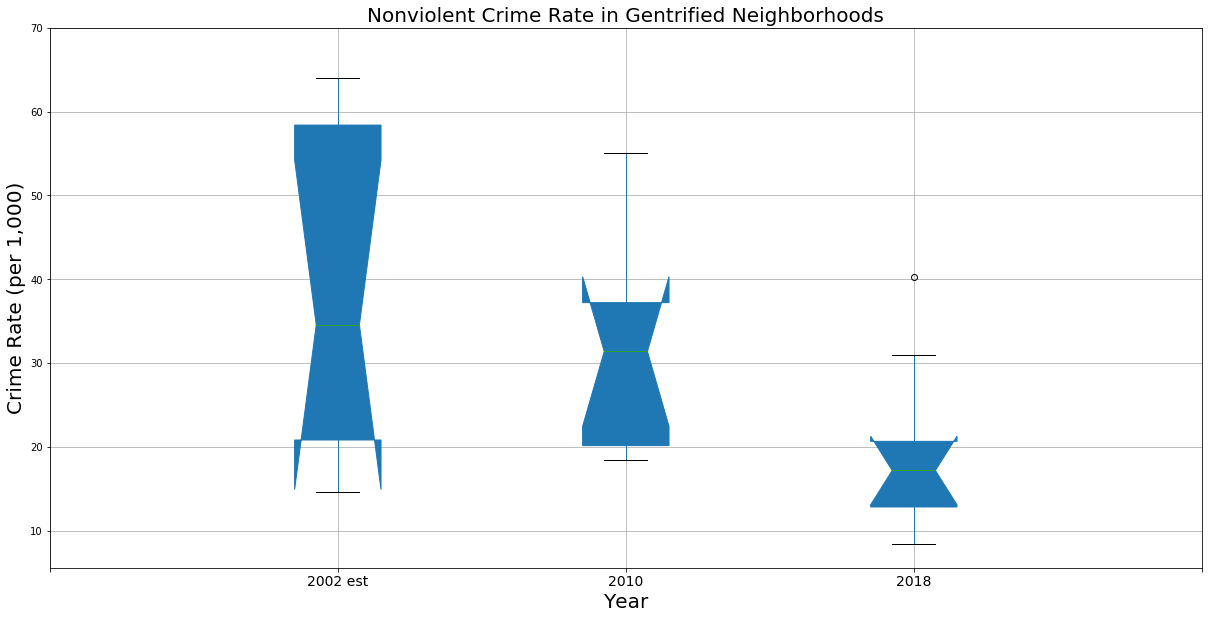

In [24]:
crimerate_nonviolent_g.boxplot("value", by="variable", notch=True, patch_artist=True, figsize=(20, 10))

plt.title('Nonviolent Crime Rate in Gentrified Neighborhoods', fontsize=20)
plt.suptitle("")

plt.xlabel('Year', fontsize=20)
plt.ylabel('Crime Rate (per 1,000)', fontsize=20)
 
# Limits for the Y axis
bars = ('','2002 est', '2010', '2018','')
y_pos = np.arange(len(bars))
    
# Create names
plt.xticks(y_pos, bars, fontsize=14)
plt.ylim(top=70)

# Export graphic
plt.savefig('output_reports_figures/gentrified_nonviolent.png')

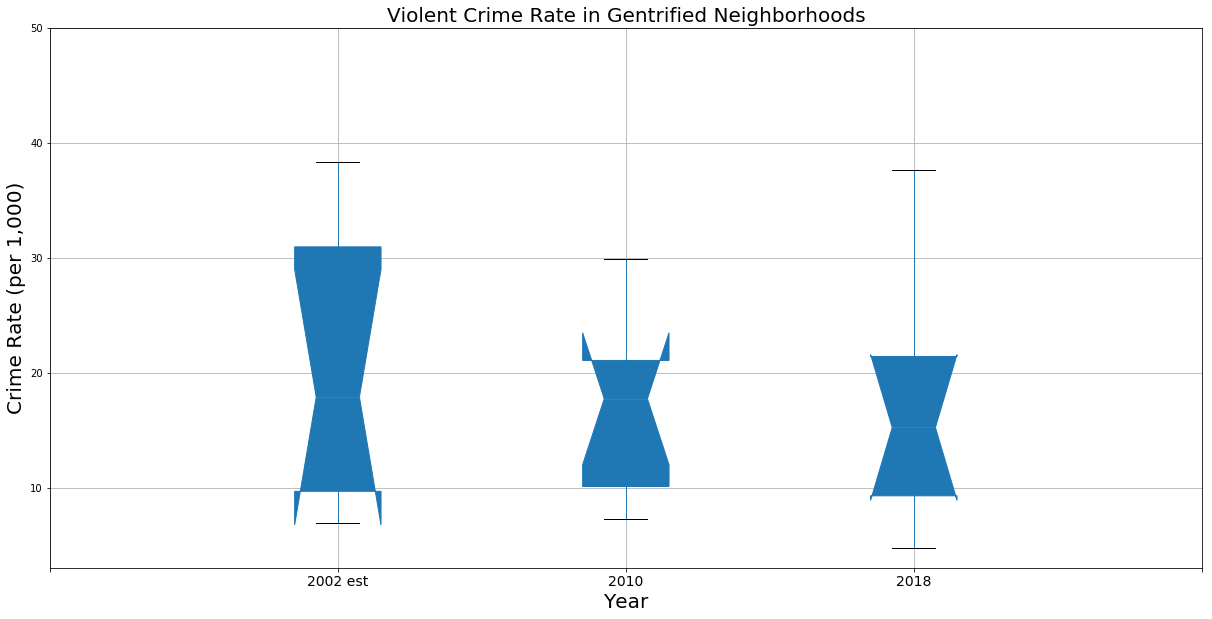

In [25]:
crimerate_violent_g.boxplot("value", by="variable", notch=True, patch_artist=True, figsize=(20, 10))

plt.title('Violent Crime Rate in Gentrified Neighborhoods', fontsize=20)
plt.suptitle("")

plt.xlabel('Year', fontsize=20)
plt.ylabel('Crime Rate (per 1,000)', fontsize=20)
 
# Limits for the Y axis
bars = ('','2002 est', '2010', '2018','')
y_pos = np.arange(len(bars))

 
# Create names
plt.xticks(y_pos, bars, fontsize=14)
plt.ylim(top=50)
 
# Export graphic
plt.savefig('output_reports_figures/gentrified_violent.png')

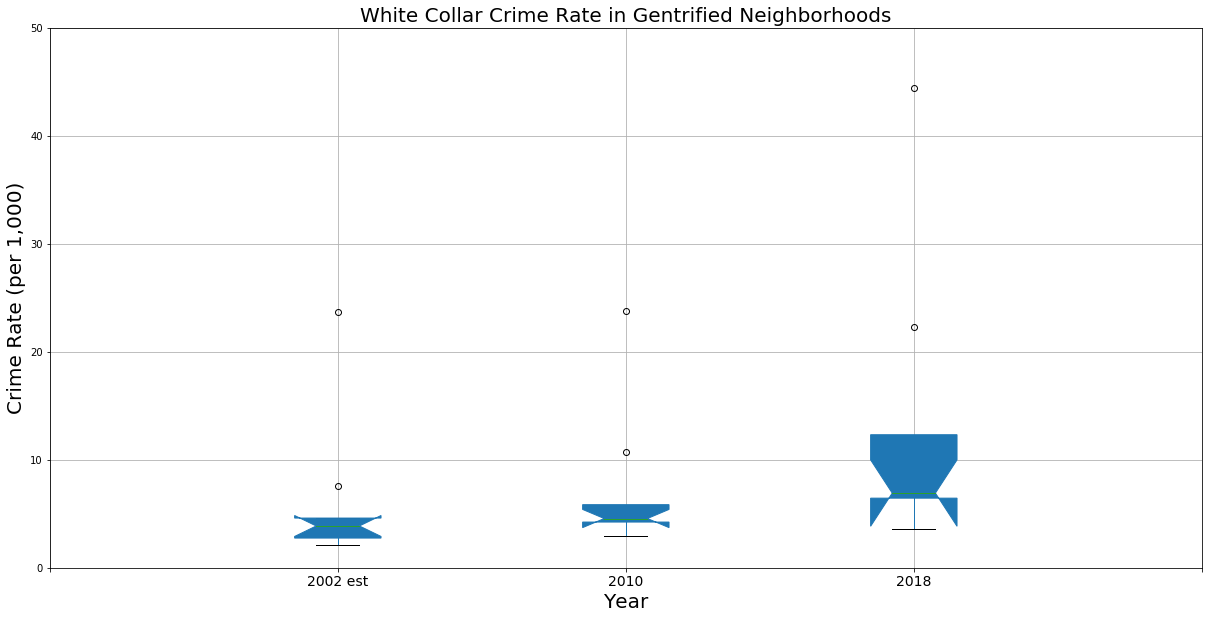

In [26]:
crimerate_white_collar_g.boxplot("value", by="variable",notch=True, patch_artist=True,  figsize=(20, 10))

plt.title('White Collar Crime Rate in Gentrified Neighborhoods', fontsize=20)
plt.suptitle("")

plt.xlabel('Year', fontsize=20)
plt.ylabel('Crime Rate (per 1,000)', fontsize=20)
 
# Limits for the Y axis
bars = ('','2002 est', '2010', '2018','')
y_pos = np.arange(len(bars))

 
# Create names
plt.xticks(y_pos, bars, fontsize=14)
plt.ylim(top=50)

# Export graphic
plt.savefig('output_reports_figures/gentrified_whitecollar.png')

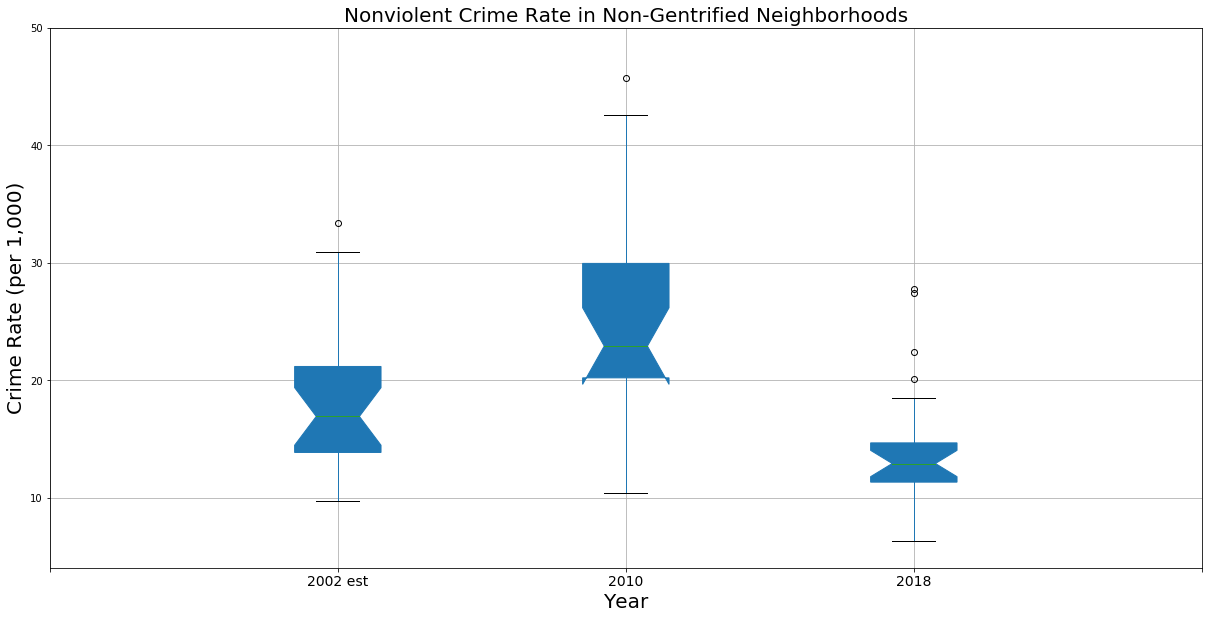

In [27]:
crimerate_nonviolent_ng.boxplot("value", by="variable", notch=True, patch_artist=True, figsize=(20, 10))

plt.title('Nonviolent Crime Rate in Non-Gentrified Neighborhoods', fontsize=20)
plt.suptitle("")

plt.xlabel('Year', fontsize=20)
plt.ylabel('Crime Rate (per 1,000)', fontsize=20)
 
# Limits for the Y axis
bars = ('','2002 est', '2010', '2018','')
y_pos = np.arange(len(bars))

 
# Create names
plt.xticks(y_pos, bars, fontsize=14)
plt.ylim(top=50)

# Export graphic
plt.savefig('output_reports_figures/nongentrified_nonviolent.png')

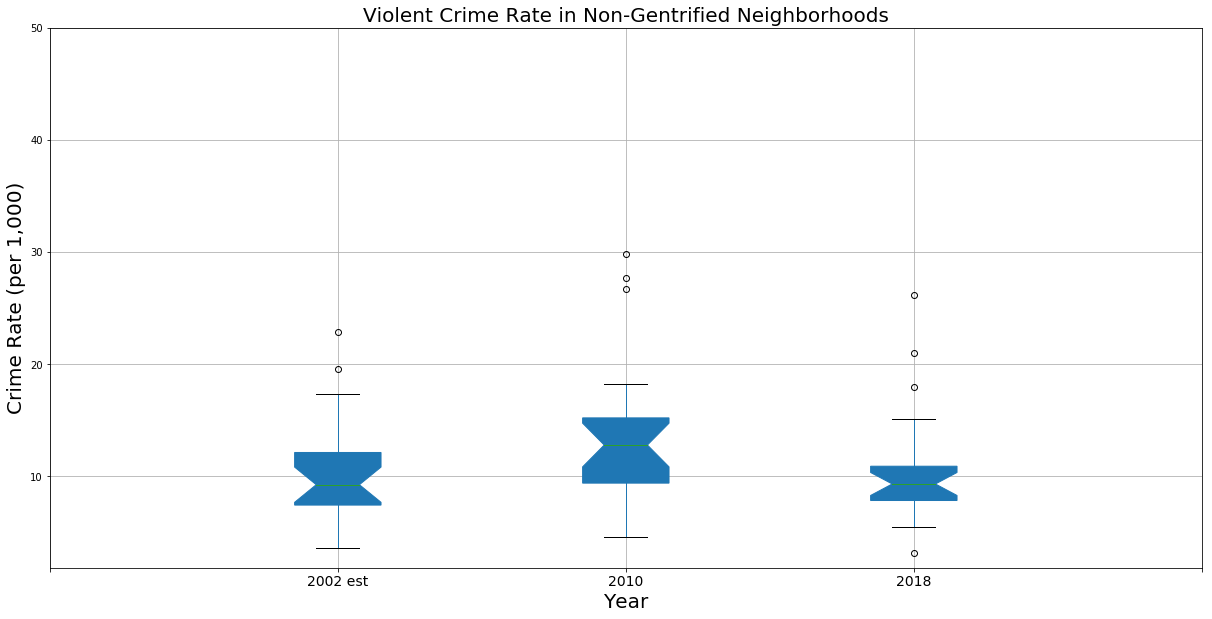

In [28]:
crimerate_violent_ng.boxplot("value", by="variable", notch=True, patch_artist=True, figsize=(20, 10))

plt.title('Violent Crime Rate in Non-Gentrified Neighborhoods', fontsize=20)
plt.suptitle("")

plt.xlabel('Year', fontsize=20)
plt.ylabel('Crime Rate (per 1,000)', fontsize=20)
 
# Limits for the Y axis
bars = ('','2002 est', '2010', '2018','')
y_pos = np.arange(len(bars))

# Create names
plt.xticks(y_pos, bars, fontsize=14)
plt.ylim(top=50)

# Export graphic
plt.savefig('output_reports_figures/nongentrified_violent.png')

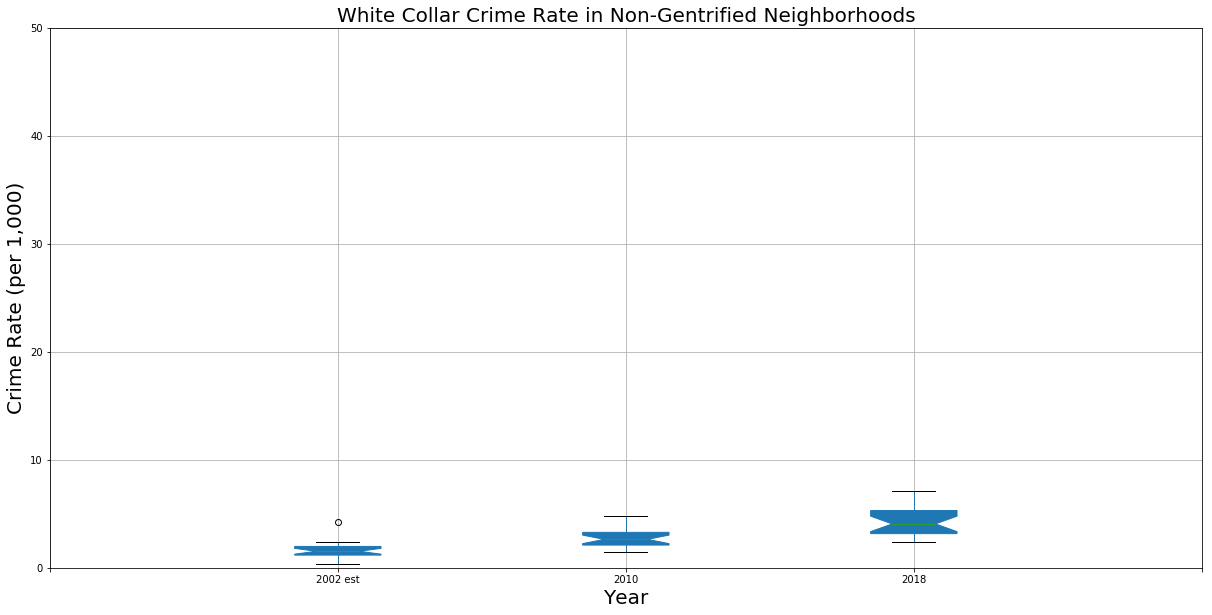

In [29]:
crimerate_white_collar_ng.boxplot("value", by="variable", notch=True, patch_artist=True, figsize=(20, 10))

plt.title('White Collar Crime Rate in Non-Gentrified Neighborhoods', fontsize=20)
plt.suptitle("")

plt.xlabel('Year', fontsize=20)
plt.ylabel('Crime Rate (per 1,000)', fontsize=20)
 
# Limits for the Y axis
bars = ('','2002 est', '2010', '2018','')
y_pos = np.arange(len(bars))

 
# Create names
plt.xticks(y_pos, bars)
plt.ylim(top=50)

# Export graphic
plt.savefig('output_reports_figures/nongentrified_whitecollar.png')


In [30]:
crimerate_all_yr = crime_all_yr_name.iloc[:,[0,1,16,17,18,19,23,27,20,24,28,21,25,29]]

#display(crime_all_yr_name.columns[[0,1,18,22,19,23,20,24,21,25]])
display(crimerate_all_yr)
crimerate_all_yr.to_csv('output_reports_figures/crimerate_all_yr.csv')

,Gentrified_type,Neighborhood,2002_POP_est,2010_POP,2018_POP,Nonviolent_2002_est_rate,Nonviolent_2010_rate,Nonviolent_2018_rate,Violent_2002_est_rate,Violent_2010_rate,Violent_2018_rate,White_Collar_2002_est_rate,White_Collar_2010_rate,White_Collar_2018_rate
0,Gentrified,Lake View,94727.0,94368,99876.0,14.589293,18.480841,10.563098,6.935721,10.109359,9.301534,2.776400,5.605714,6.938604
1,Gentrified,Lincoln Park,64279.0,64116,67260.0,18.077444,20.150976,12.830806,7.840819,8.593799,7.062147,3.251451,4.585439,6.526910
2,Gentrified,Loop,18967.0,29283,35010.0,64.005905,55.049005,40.245644,30.948489,28.378240,37.646387,23.725418,23.836356,44.473008
3,Gentrified,Near North Side,74346.0,80484,86343.0,37.984559,34.789523,20.661779,20.875367,20.476119,21.414591,7.626503,10.759903,22.341128
4,Gentrified,Near South Side,11885.0,21390,23190.0,58.392932,26.273960,18.628719,38.367690,16.549790,15.610177,4.627682,4.067321,10.219922
5,Gentrified,Near West Side,48111.0,54881,62560.0,59.030159,50.655054,31.010230,31.552036,29.864616,25.895141,4.427262,5.867240,12.340153
6,Gentrified,North Center,31889.0,31867,34942.0,20.822227,18.639972,8.356705,9.689862,7.311639,4.722111,2.195114,3.012521,3.634594
7,Gentrified,Uptown,62113.0,56362,56296.0,27.707565,31.386395,14.814552,16.373384,17.742451,15.240870,3.896125,4.258188,6.288191
8,Gentrified,West Town,86395.0,82236,85307.0,34.562185,37.209981,17.184991,17.882979,21.073496,12.835992,2.141328,4.462766,6.470747
9,Not Gentrified,Armour Square,12304.0,13391,13699.0,21.293888,33.231275,14.526608,9.184005,16.578299,15.110592,1.219116,3.360466,5.474852


### Run Anova tests by crime and neighborhood type across years (This may be the wrong use of ANOVA)
* format as dataframe of F-Statistics and P-values
* Send the dataframe to output reports as a csv

In [31]:
Nonviolent_2002_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Gentrified"]["Nonviolent_2002_est_rate"]
Nonviolent_2010_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Gentrified"]["Nonviolent_2010_rate"]
Nonviolent_2018_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Gentrified"]["Nonviolent_2018_rate"]
Nonviolent_gentrified_f_val, Nonviolent_gentrified_p_val = stats.f_oneway(Nonviolent_2002_gentrified, Nonviolent_2010_gentrified, Nonviolent_2018_gentrified)

Violent_2002_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Gentrified"]["Violent_2002_est_rate"]
Violent_2010_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Gentrified"]["Violent_2010_rate"]
Violent_2018_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Gentrified"]["Violent_2018_rate"]
Violent_gentrified_f_val, Violent_gentrified_p_val = stats.f_oneway(Violent_2002_gentrified, Violent_2010_gentrified, Violent_2018_gentrified)

White_Collar_2002_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Gentrified"]["White_Collar_2002_est_rate"]
White_Collar_2010_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Gentrified"]["White_Collar_2010_rate"]
White_Collar_2018_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Gentrified"]["White_Collar_2018_rate"]
White_Collar_gentrified_f_val, White_Collar_gentrified_p_val = stats.f_oneway(White_Collar_2002_gentrified, White_Collar_2010_gentrified, White_Collar_2018_gentrified)

Nonviolent_2002_not_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Not Gentrified"]["Nonviolent_2002_est_rate"]
Nonviolent_2010_not_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Not Gentrified"]["Nonviolent_2010_rate"]
Nonviolent_2018_not_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Not Gentrified"]["Nonviolent_2018_rate"]
Nonviolent_not_gentrified_f_val, Nonviolent_not_gentrified_p_val = stats.f_oneway(Nonviolent_2002_not_gentrified, 
                                                                                  Nonviolent_2010_not_gentrified, 
                                                                                  Nonviolent_2018_not_gentrified)

Violent_2002_not_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Not Gentrified"]["Violent_2002_est_rate"]
Violent_2010_not_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Not Gentrified"]["Violent_2010_rate"]
Violent_2018_not_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Not Gentrified"]["Violent_2018_rate"]
Violent_not_gentrified_f_val, Violent_not_gentrified_p_val = stats.f_oneway(Violent_2002_not_gentrified, 
                                                                            Violent_2010_not_gentrified, 
                                                                            Violent_2018_not_gentrified)

White_Collar_2002_not_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Not Gentrified"]["White_Collar_2002_est_rate"]
White_Collar_2010_not_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Not Gentrified"]["White_Collar_2010_rate"]
White_Collar_2018_not_gentrified = crimerate_all_yr[crimerate_all_yr["Gentrified_type"] == "Not Gentrified"]["White_Collar_2018_rate"]
White_Collar_not_gentrified_f_val, White_Collar_not_gentrified_p_val = stats.f_oneway(White_Collar_2002_not_gentrified, 
                                                                                      White_Collar_2010_not_gentrified, 
                                                                                      White_Collar_2018_not_gentrified)


neighborhoodcrime_anova = pd.DataFrame( {"F-Statistic" : [Nonviolent_gentrified_f_val, 
                                     Violent_gentrified_f_val,
                                     White_Collar_gentrified_f_val,
                                    Nonviolent_not_gentrified_f_val,
                                     Violent_not_gentrified_f_val,
                                     White_Collar_not_gentrified_f_val,
                                    ] ,
                    "P-Value" : [Nonviolent_gentrified_p_val, 
                                 Violent_gentrified_p_val,
                                White_Collar_gentrified_p_val,
                                 Nonviolent_not_gentrified_p_val,
                                 Violent_not_gentrified_p_val,
                                 White_Collar_not_gentrified_p_val,
                                ]}, 
                      index = ['Nonviolent_gentrified', 
                               'Violent_gentrified',
                               'White_Collar_gentrified',
                               'Nonviolent_not_gentrified', 
                               'Violent_not_gentrified',
                               'White_Collar_not_gentrified',])
neighborhoodcrime_anova
neighborhoodcrime_anova.to_csv('output_reports_figures/neighborhoodcrime_anova.csv')